In [1]:
'''
This script uses the EV Charging behaviours dataset (xlsx format)
The script aims to explain what makes people charge AC or DC
Decision trees, boosted trees and regression are used
'''

'\nThis script uses the EV Charging behaviours dataset (xlsx format)\nThe script aims to explain what makes people charge AC or DC\nDecision trees, boosted trees and regression are used\n'

In [2]:
import numpy as np
import datetime as dt
import sklearn
import pandas as pd
from sklearn import preprocessing 

In [3]:
# read data

df = pd.read_excel (r'Data/EV Charging behaviours.xlsx',sheet_name='enlarged data')
X=df.copy()

In [4]:
# encoding of non numerical data

from sklearn.preprocessing import OneHotEncoder

le = preprocessing.LabelEncoder()
X['medewerker'] = le.fit_transform(X['medewerker'])
X['Kaart ID'] = le.fit_transform(X['Kaart ID'])
X['Platform'] = le.fit_transform(X['Platform'])
X['Number plate'] = le.fit_transform(X['Number plate'].astype(str))
#X['car type'] = le.fit_transform(X['car type'].astype(str))
#X['car type'] = X['car type'].astype(str)
X['Locatie'] = le.fit_transform(X['Locatie'])
X['Land'] = le.fit_transform(X['Land'])
X['AC or DC'] = le.fit_transform(X['AC or DC'])
X['Laadpaaltype'] = le.fit_transform(X['Laadpaaltype'])
X['Laadpaal_ID'] = le.fit_transform(X['Laadpaal_ID'].astype(str))
X['Laadpaalexploitant'] = le.fit_transform(X['Laadpaalexploitant'].astype(str))
X['Driver has home charger'] = le.fit_transform(X['Driver has home charger'].astype(str))


enc = OneHotEncoder(handle_unknown='ignore')
# passing bridge-types-cat column (label encoded values of bridge_types)
enc_df = pd.DataFrame(enc.fit_transform(X[['Main Office','car type','Weekday']]).toarray())
# merge with main df bridge_df on key values
X = X.join(enc_df)



In [5]:
#clean data

X=X.dropna()

In [6]:
# select target feature to predict

y_ACDC=X['AC or DC']
y_ACDC = le.fit_transform(y_ACDC.astype(str))

In [7]:
# Decide what features to take into account in the model


duration = False
percent_charged= True
battery_size=True
percent_laadpaal=False
Geladen_kWh=True
home_charger=True
main_office=True
car_type=True
year=True
weekday=True

In [8]:
# select features


selection=[]
labels=[]

if duration:
    selection.append('Duration in minutes')
if percent_charged:
    selection.append('% of battery charged')
if battery_size:
    selection.append('Battery size')
if percent_laadpaal:
    selection.append('% laadpaal vermogen')
if percent_laadpaal:
    selection.append('Geladen kWh')
if home_charger:
    selection.append('Driver has home charger')
if year:
    selection.append('Year')
    
    
labels=selection.copy()
used_params=selection.copy()
onehot_counter=0


offices=X['Main Office'].unique()
nb_officess=len(offices.tolist())
if main_office:
    classes=[onehot_counter+i for i in range(nb_officess)]
    selection=selection+classes
    labels=labels+offices.tolist()
    used_params.append('Main office')
onehot_counter=onehot_counter+nb_officess

car_types=X['car type'].unique()
nb_car_types=len(car_types.tolist())
if car_type:
    classes=[onehot_counter+i for i in range(nb_car_types)]
    selection=selection+classes
    labels=labels+car_types.tolist()
    used_params.append('car type')
onehot_counter=onehot_counter+nb_car_types

weekdays=X['Weekday'].unique()
nb_weekdays=7
if car_type:
    classes=[onehot_counter+i for i in range(nb_weekdays)]
    selection=selection+classes
    labels=labels+weekdays.tolist()
    used_params.append('Weekday')
onehot_counter=onehot_counter+nb_weekdays
    

X_selection= X[selection]


In [9]:
# fit tree
# adjust max_depth for depth of tree (avoid overfitting)

from sklearn import tree
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_selection, y_ACDC, test_size=0.33, random_state=42)

clf_ACDC = tree.DecisionTreeClassifier(max_depth=5,min_samples_leaf=5,criterion='gini')
clf_ACDC = clf_ACDC.fit(X_train, y_train)

In [10]:
#plot tree

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# create tree object 

# train the model using the training sets and check score
print(clf_ACDC.score(X_selection, y_ACDC))


fig=plt.figure(figsize=(100,100),dpi=100)
_=tree.plot_tree(clf_ACDC, filled=True,feature_names=labels,class_names=['AC','DC'])
plt.title("Decision tree")
fig.savefig("decistion_tree"+str(used_params)+".png")

plt.show()



0.9692157890794697


In [11]:
# evaluate classifier (tree)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

print('train score:' + str(clf_ACDC.score(X_train, y_train)))
print('test score:' + str(clf_ACDC.score(X_test, y_test)))


from sklearn.metrics import precision_score

y_pred=clf_ACDC.predict(X_test)
precision_score(y_test, y_pred)

train score:0.9688093907210732
test score:0.9700408533817522


0.26666666666666666

In [12]:
# boosted tree

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

boosted_clf=GradientBoostingClassifier()
boosted_clf=boosted_clf.fit(X_train, y_train)

print('train score boosted:' + str(boosted_clf.score(X_train, y_train)))
print('test score boosted:' + str(boosted_clf.score(X_test, y_test)))

y_pred_boosted=boosted_clf.predict(X_test)
precision_score(y_test, y_pred_boosted)


train score boosted:0.9700391280044718
test score boosted:0.9709487063095779


0.3333333333333333

In [13]:
# regression

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

reg_clf=LinearRegression()
reg_clf=reg_clf.fit(X_train, y_train)

reg_log_clf=LogisticRegression()
reg_log_clf=reg_log_clf.fit(X_train, y_train)


print('train score lin reg:' + str(reg_clf.score(X_train, y_train)))
print('test score lin reg:' + str(reg_clf.score(X_test, y_test)))

print('train score log reg:' + str(reg_log_clf.score(X_train, y_train)))
print('test score log reg:' + str(reg_log_clf.score(X_test, y_test)))

y_pred_reg=reg_clf.predict(X_test)
print(len(y_pred_reg))
print(y_pred_reg)
for i in range(len(y_pred_reg)):
    if y_pred_reg[i] >=0.5:
        y_pred_reg[i]=1
    else:
        y_pred_reg[i]=0
print(y_pred_reg)

print('precision_score lin reg' + str(precision_score(y_test, y_pred_reg)))

#y_pred_reg_log=reg_log_clf.predict(X_test)
#print(y_pred_reg_log)
#print('precision_score log reg' + str(precision_score(y_test, y_pred_reg_log)))


train score lin reg:0.03809324615543763
test score lin reg:0.035800708785908686
train score log reg:0.967915036333147
test score log reg:0.9716295960054471
4406
[ 0.06827422 -0.02428077  0.03863347 ...  0.0364793   0.07875773
  0.01934064]
[0. 0. 0. ... 0. 0. 0.]
precision_score lin reg0.0


C:\Programdata\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0 0 0 ... 0 0 0]
[ 0.06827422 -0.02428077  0.03863347 ...  0.0364793   0.07875773
  0.01934064]


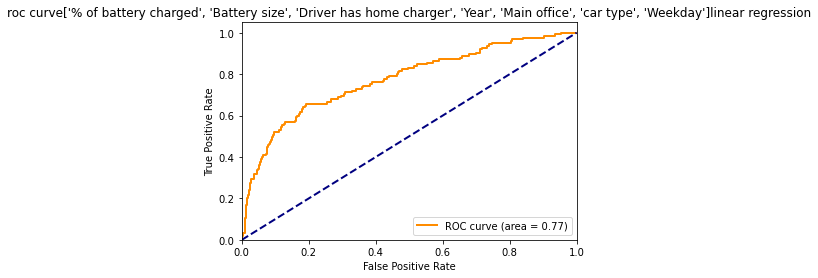

In [15]:
# roc curve

from sklearn import metrics
from sklearn.metrics import roc_curve, auc
y_pred_reg=reg_clf.predict(X_test)

fpr, tpr, thresholds=metrics.roc_curve(y_test, y_pred_reg)
print(y_test)
print(y_pred_reg)

auc=metrics.auc(fpr, tpr)

fig=plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
title_fig="roc curve"+str(used_params)+'linear regression'
plt.title(title_fig)
plt.legend(loc="lower right")

fig.savefig(title_fig+".png")

plt.show()
